# Problem Statement - 
Build your own recommendation system for products on an e-commerce website like Amazon.com.
Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. 
Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
In this project we are going to build recommendation model for the electronics products of Amazon. 
The dataset here is taken from the below website. 
Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Please do the analysis based on steps( 1 to 8) as given below - 
Steps -
1.	Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)
2.	Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
3.	Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
4.	Build Popularity Recommender model.
5.	Build Collaborative Filtering model.
6.	Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7.	Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
8.	Summarise your insights.


In [1]:
# importing necessary libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import seaborn as sns
import numpy as np
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings;warnings.simplefilter('ignore')
%matplotlib inline


In [2]:
# reading the raw dataset
df = pd.read_csv('ratings_Electronics.csv')

In [3]:
# looking inside the data
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
# fetching the number of rows and columns
df.shape

(7824481, 4)

In [5]:
# preparing a list of column headers
column_header = ['userId','productId','ratings','timestamp']

In [6]:
# Adding the column headers in the dataframe
df = pd.read_csv('ratings_Electronics.csv',header=None,names=column_header)

In [7]:
# looking into the dataset for the headers
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
# In our analysis dataset, 'timestamp' column is less important hence dropping the column
df.drop('timestamp',axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [10]:
df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [11]:
#Cheching for any null values
df.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [12]:
# In popularity based model or in collaborative filtering we consider those users who gave more ratings as we can't say a 
# product is popular based on one user's rating and also to avoid huge dataset it is essential that we eliminate 
# users who gave very less number of ratings
# In this dataset we filter out users who gave less than 50 ratings
# Taking a subset of the dataset , considering those records where count of userID is more than 50
counts = df['userId'].value_counts()
df_final = df[df['userId'].isin(counts[counts>=50].index)]

In [13]:
df_final.shape

(125871, 3)

In [14]:
# df_final is the subset of the dataset df where the we have 125871 records compared to 7824481 records which we have earlier

In [15]:
# Now plotting histograms
ratings_hist = pd.DataFrame(df.groupby('productId')['ratings'].mean())
ratings_hist.head()

,ratings
productId,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852


In [16]:
ratings_hist['number_of_ratings'] = df.groupby('productId')['ratings'].count()
ratings_hist.head()

,ratings,number_of_ratings
productId,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27


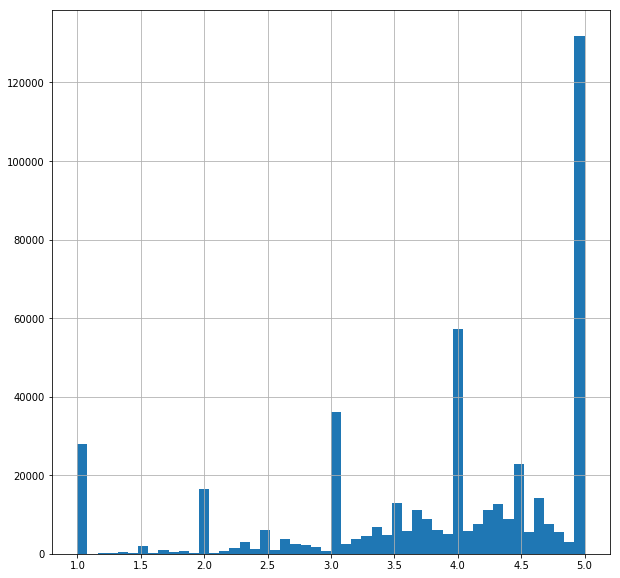

In [17]:
ratings_hist['ratings'].hist(bins=50,figsize=(10,10))

In [18]:
# Most of the ratings are between 4.0 and 5.0

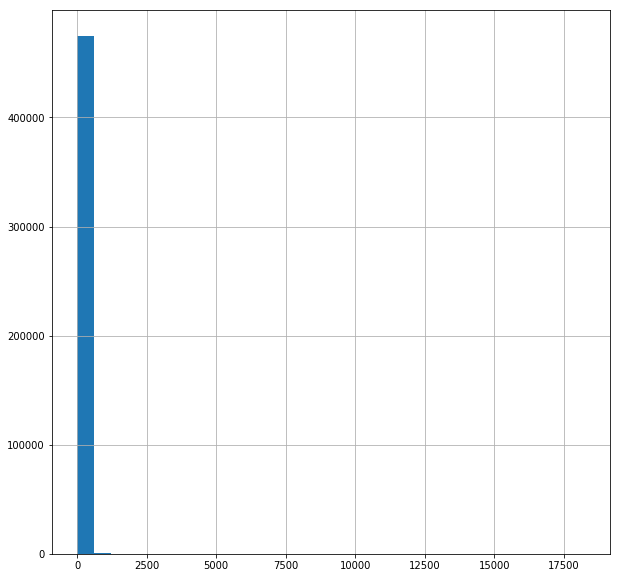

In [19]:
ratings_hist['number_of_ratings'].hist(bins =30,figsize=(10,10))

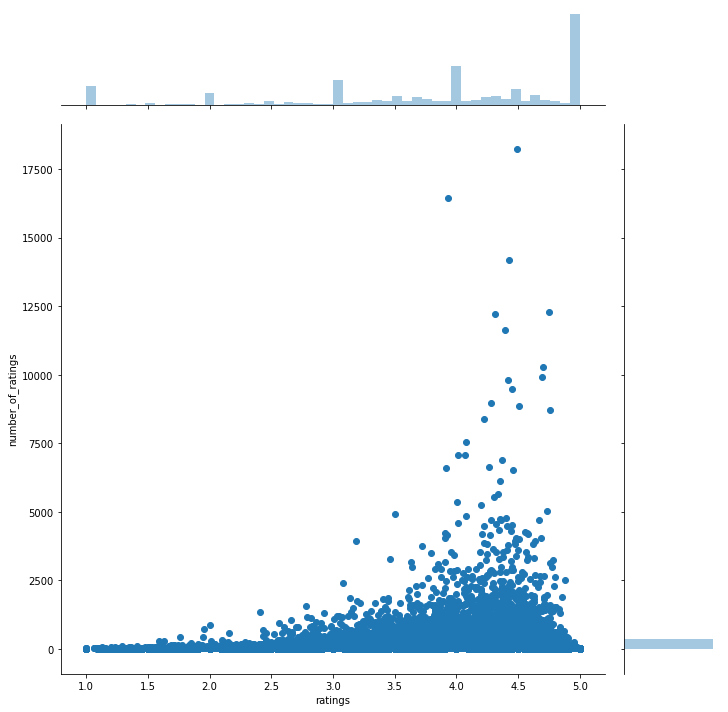

In [20]:
import seaborn as sns
sns.jointplot(x='ratings', y='number_of_ratings', data=ratings_hist,height=10)

In [21]:
# Now let us look into the top 10 users who gave highest number of ratings
df_final.groupby('userId').size().sort_values(ascending=False)[:10]

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [22]:
df_final.head()

,userId,productId,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [23]:
train_data,test_data = train_test_split(df_final,test_size=0.30,random_state=0)
train_data.head()

,userId,productId,ratings
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


# Building a basic Popularity model

In [24]:
#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['userId'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

In [25]:
import time
from sklearn.model_selection import train_test_split

In [26]:
df_final_grouped = df_final.groupby(['productId']).agg({'ratings' : 'count'}).reset_index()

In [27]:
grouped_sum = df_final_grouped['ratings'].sum()

In [28]:
print(grouped_sum)

125871


In [29]:
df_final_grouped['percentage'] = df_final_grouped['ratings'].div(grouped_sum)*100

In [30]:
df_final_grouped.sort_values(['ratings', 'productId'], ascending = [0,1]).head()

,productId,ratings,percentage
39003,B0088CJT4U,206,0.163660
24827,B003ES5ZUU,184,0.146181
11078,B000N99BBC,167,0.132676
38250,B007WTAJTO,164,0.130292
38615,B00829TIEK,149,0.118375


In [31]:
users = df_final['userId'].unique()
len(users)

1540

In [32]:
products = df_final['productId'].unique()
len(products)

48190

In [33]:
train_data, test_data = train_test_split(df_final, test_size = 0.30, random_state = 0)

In [34]:
pm = popularity_recommender_py()

In [35]:
pm.create(train_data, 'userId', 'productId')

In [36]:
user_id = users[0:5]

In [37]:
# Predicting recommendations for five users
for user in user_id:
    print(f"Predicting top five recommendations for user {user} : ")
    inputval = user
    pm.recommend(inputval).head(5)
    print('*'*40)

Predicting top five recommendations for user A3BY5KCNQZXV5U : 


,userId,productId,score,Rank
30847,A3BY5KCNQZXV5U,B0088CJT4U,133,1.0
30287,A3BY5KCNQZXV5U,B007WTAJTO,124,2.0
19647,A3BY5KCNQZXV5U,B003ES5ZUU,122,3.0
8752,A3BY5KCNQZXV5U,B000N99BBC,114,4.0
30555,A3BY5KCNQZXV5U,B00829THK0,97,5.0


****************************************
Predicting top five recommendations for user AT09WGFUM934H : 


,userId,productId,score,Rank
30847,AT09WGFUM934H,B0088CJT4U,133,1.0
30287,AT09WGFUM934H,B007WTAJTO,124,2.0
19647,AT09WGFUM934H,B003ES5ZUU,122,3.0
8752,AT09WGFUM934H,B000N99BBC,114,4.0
30555,AT09WGFUM934H,B00829THK0,97,5.0


****************************************
Predicting top five recommendations for user A32HSNCNPRUMTR : 


,userId,productId,score,Rank
30847,A32HSNCNPRUMTR,B0088CJT4U,133,1.0
30287,A32HSNCNPRUMTR,B007WTAJTO,124,2.0
19647,A32HSNCNPRUMTR,B003ES5ZUU,122,3.0
8752,A32HSNCNPRUMTR,B000N99BBC,114,4.0
30555,A32HSNCNPRUMTR,B00829THK0,97,5.0


****************************************
Predicting top five recommendations for user A17HMM1M7T9PJ1 : 


,userId,productId,score,Rank
30847,A17HMM1M7T9PJ1,B0088CJT4U,133,1.0
30287,A17HMM1M7T9PJ1,B007WTAJTO,124,2.0
19647,A17HMM1M7T9PJ1,B003ES5ZUU,122,3.0
8752,A17HMM1M7T9PJ1,B000N99BBC,114,4.0
30555,A17HMM1M7T9PJ1,B00829THK0,97,5.0


****************************************
Predicting top five recommendations for user A3CLWR1UUZT6TG : 


,userId,productId,score,Rank
30847,A3CLWR1UUZT6TG,B0088CJT4U,133,1.0
30287,A3CLWR1UUZT6TG,B007WTAJTO,124,2.0
19647,A3CLWR1UUZT6TG,B003ES5ZUU,122,3.0
8752,A3CLWR1UUZT6TG,B000N99BBC,114,4.0
30555,A3CLWR1UUZT6TG,B00829THK0,97,5.0


****************************************


# Building Collaborative filtering model without using surprise package and using SVD

In [38]:
df_ibcf = df_final.copy()

In [39]:
df_ibcf.head()

,userId,productId,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [40]:
df_ibcf.shape

(125871, 3)

In [41]:
trainDF, tempDF = train_test_split(df_ibcf, test_size = 0.30, random_state = 100)

In [42]:
testDF = tempDF.copy()

In [43]:
tempDF.rating = np.nan

In [44]:
tempDF.head()

,userId,productId,ratings
3071497,AWH2AY17ZU7W2,B0035JCI6M,3.0
1270452,A2MSBIA18RXYQC,B000P1711K,1.0
1506249,A1H98YV5K5BUX0,B000WZ7Y5C,5.0
7709306,A2X8KN82L07RSK,B00GO4GMAI,5.0
2570183,AU627A4UGIW6V,B002EPF6YO,4.0


In [45]:
testDF = testDF.dropna()

In [46]:
testDF.head()

,userId,productId,ratings
3071497,AWH2AY17ZU7W2,B0035JCI6M,3.0
1270452,A2MSBIA18RXYQC,B000P1711K,1.0
1506249,A1H98YV5K5BUX0,B000WZ7Y5C,5.0
7709306,A2X8KN82L07RSK,B00GO4GMAI,5.0
2570183,AU627A4UGIW6V,B002EPF6YO,4.0


In [47]:
ratings = pd.concat([trainDF, tempDF]).reset_index()

In [48]:
ratings.head()

,index,userId,productId,ratings
0,5993538,ANW6EGY12V5XS,B007ZW43IQ,4.0
1,4459175,A1QVFHPY8418HC,B004T9Y0MW,5.0
2,2177400,ALDAF4VVLFRHP,B001NOG2T0,4.0
3,232287,A11YIHB6IW352W,B00007KDVI,5.0
4,7811983,A3PD8JD9L4WEII,B00JGSWU7S,5.0


In [49]:
R_df = ratings.pivot(index = 'userId', columns = 'productId', values = 'ratings').fillna(0)

In [50]:
R_df.tail()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZNUHQSHZHSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZOK5STV85FBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
from scipy.sparse.linalg import svds

In [52]:
U, sigma, Vt = svds(R_df, k = 50)

In [53]:
sigma

array([ 66.16942358,  66.26045906,  66.5326469 ,  66.73322244,
        66.90754989,  67.13857643,  67.52729531,  67.65247592,
        67.97832692,  68.1926043 ,  68.431321  ,  68.70278398,
        69.17715066,  69.84552982,  69.98332317,  70.19621309,
        70.3835867 ,  70.5901626 ,  70.99498997,  71.47879811,
        71.60653312,  72.39116477,  72.94294663,  73.4307746 ,
        73.49070971,  74.13638941,  74.28327666,  74.47029584,
        74.99962629,  75.70165196,  76.31608552,  76.53336712,
        77.34117065,  77.76866606,  78.63158661,  79.39214749,
        80.2967454 ,  80.95856309,  82.19795763,  83.3788163 ,
        87.43474122,  88.68897677,  91.15027972,  92.15989229,
        95.03789667,  98.21626326, 100.38232831, 107.7090351 ,
       119.69501814, 182.29276718])

In [54]:
sigma = np.diag(sigma)

In [55]:
sigma

array([[ 66.16942358,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  66.26045906,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  66.5326469 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 107.7090351 ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        119.69501814,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 182.29276718]])

In [56]:
all_users_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [57]:
preds_df = pd.DataFrame(all_users_predicted_ratings, columns = R_df.columns)

In [58]:
preds_df

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770
5,0.000311,-0.000105,0.003827,0.002570,0.005422,-0.002457,0.005309,0.004040,-0.007449,-0.000979,...,-0.000370,0.091134,0.000260,0.039292,0.029386,-0.000020,-0.003785,0.015064,-0.049641,0.016478
6,0.003288,0.007071,-0.002792,0.004335,0.000284,0.002187,-0.000012,-0.001257,0.011732,0.001605,...,0.000121,-0.058274,-0.000174,-0.049992,0.013276,0.001588,0.013399,-0.038722,-0.013914,-0.008550
7,0.015611,0.033296,-0.000499,-0.070398,0.009782,0.010123,-0.015320,0.000704,0.013545,0.008784,...,0.002167,0.104971,0.021792,0.122125,0.013596,0.002983,0.006974,0.034022,0.052811,0.000810
8,-0.001738,-0.000504,-0.002768,0.102026,0.005424,-0.001882,-0.011188,0.017720,0.012296,-0.000812,...,-0.000650,0.043663,0.003391,-0.095637,0.017260,-0.005323,0.000063,0.064849,-0.064410,0.045463
9,0.005716,0.012512,-0.000978,-0.013010,0.015682,0.008826,-0.011782,0.002861,0.002098,0.007464,...,0.000518,0.008941,0.002580,-0.037062,0.031302,-0.001298,0.009275,-0.012566,-0.022399,0.014720


In [59]:
def recommend_items(userId,pivot_df,preds_df,num_recommendations):
    user_idx = userId-1 # index starts at 0
    #Get and sort the user ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending = False)
    #Sorted user ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending = False)
    #sorted user predictions
    
    temp = pd.concat([sorted_user_ratings,sorted_user_predictions],axis=1)
    temp.index.name='Recommended Items'
    temp.columns = ['user_ratings','user_predictions']
    
    temp = temp.loc[temp.user_ratings==0]
    temp = temp.sort_values('user_predictions',ascending=False)
    print(f"Below are the recommended items for user having user_index as : {userId}")
    print(temp.head(num_recommendations))

In [60]:
UserIDs = range(1,11)
num_recommendations=5
for i in UserIDs:
    recommend_items(i,R_df,preds_df,num_recommendations)
    print('-'*40)

Below are the recommended items for user having user_index as : 1
                   user_ratings  user_predictions
Recommended Items                                
B0019EHU8G                  0.0          1.407411
B003ES5ZUU                  0.0          1.097482
B007OY5V68                  0.0          0.987353
B000JMJWV2                  0.0          0.946122
B009SYZ8OC                  0.0          0.847875
----------------------------------------
Below are the recommended items for user having user_index as : 2
                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.825135
B004CLYEDC                  0.0          1.250059
B001TH7GSW                  0.0          1.006211
B00834SJSK                  0.0          0.947728
B00AQRUW4Q                  0.0          0.757301
----------------------------------------
Below are the recommended items for user having user_index as : 3
                   u

In [61]:
rmse_df = pd.concat([R_df.mean(),preds_df.mean()],axis=1)

rmse_df.columns = ['Avg_actual_ratings','Avg_predicted_ratings']
# rmse_df.dropna(axis=0,inplace=True)
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0,rmse_df.shape[0],1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [62]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings)**2).mean()**0.5),5)
print(f"RMSE SVD Model = {RMSE}")

RMSE SVD Model = 0.00275


# RMSE SVD Model = 0.00275

# Item based Collaborative Filtering with KNNWithMeans using surprise package

In [63]:
from surprise import Dataset,Reader
from surprise import KNNWithMeans
reader = Reader(rating_scale=(1, 5))

In [64]:
df_final.shape

(125871, 3)

In [65]:
# Lets exclude movies with very few ratings, say less than 5, this is done to avoid memory error while trying to feed the model
product_count = df_final["productId"].value_counts(ascending=False)
pop_product = product_count.loc[product_count.values > 15].index
len(pop_product)

955

In [66]:
ratings = df_final.loc[df_final.productId.isin(pop_product)]
ratings.shape

(27265, 3)

In [67]:
data = Dataset.load_from_df(ratings[['userId', 'productId', 'ratings']], reader)

In [68]:
data

In [69]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

# to build on full data
#trainset = data.build_full_trainset()

In [70]:
# To use item-based pearson similarity
sim_options = {
    "name": "pearson",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [71]:
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [72]:
from surprise import accuracy
# Evalute on test set
test_pred = algo.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9599


0.9599195493637213

# Tuning the Algorithm Parameters for KNNWithMeans

#We are not getting a good RMSE value hence we need to tune the algorithm parameters

In [73]:
from surprise.model_selection import GridSearchCV

In [74]:
sim_options = {
    "name": ["msd", "cosine" , "pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [75]:
# The hyper parameters
# 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}

In [76]:
sim_options = {
    "name": "pearson",
    "min_support":5,
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [77]:
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [78]:
# Evalute on test set
test_pred = algo.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9220


0.9220172056096549

In [79]:
# After applying the hyper parameters we get a slight decresae in the RMSE value , which means the performance of our model increases

In [80]:
# View a particular prediction
test_pred[12]

# To access a particular value, say estimate simply mention test_pred[12].est

Prediction(uid='A2W9GX82SLKROQ', iid='B00BWL33H8', r_ui=4.0, est=4.318181818181818, details={'actual_k': 0, 'was_impossible': False})

In [81]:
# convert results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["was_impossible"] = [x["was_impossible"] for x in test_pred_df["details"]]

In [82]:
test_pred_df.head()

,uid,iid,r_ui,est,details,was_impossible
0,A1ODOGXEYECQQ8,B00DDK1QUC,4.0,3.811111,"{'actual_k': 1, 'was_impossible': False}",False
1,A10Y058K7B96C6,B008OEHV6U,3.0,3.583333,"{'actual_k': 0, 'was_impossible': False}",False
2,A2NJQF2UI60VGT,B002ZCXJZE,5.0,4.521739,"{'actual_k': 0, 'was_impossible': False}",False
3,A11T807LX2EF00,B003CFATT2,5.0,4.833333,"{'actual_k': 0, 'was_impossible': False}",False
4,A2K6CDQ9HZ359G,B004T9RR6I,4.0,3.969697,"{'actual_k': 0, 'was_impossible': False}",False


In [83]:
# The significancce of 'was_impossible' is that True means there are no sufficient data to derive any logic for recommendation and False means that is is possible to recommend value based on data provided

In [84]:
### Predictions
# Mkae prediction for a single user
algo.predict(uid="A1ODOGXEYECQQ8",iid="B00DDK1QUC")

Prediction(uid='A1ODOGXEYECQQ8', iid='B00DDK1QUC', r_ui=None, est=3.811111111111111, details={'actual_k': 1, 'was_impossible': False})

In [85]:
### Generating top n recommendations
testset_new = trainset.build_anti_testset()

In [86]:
len(testset_new)

1427740

In [87]:
testset_new[0:5]

[('A2UKE7GIVC7XFW', 'B001CCAISE', 4.348860361540477),
 ('A2UKE7GIVC7XFW', 'B000LRMS66', 4.348860361540477),
 ('A2UKE7GIVC7XFW', 'B00B4OCWE8', 4.348860361540477),
 ('A2UKE7GIVC7XFW', 'B000AZ57M6', 4.348860361540477),
 ('A2UKE7GIVC7XFW', 'B004CLYEH8', 4.348860361540477)]

In [88]:
predictions = algo.test(testset_new[0:10000])

In [89]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])
predictions_df.columns = ["userId","productId","est_rating"]
predictions_df.sort_values(by = ["userId", "est_rating"],ascending=False,inplace=True)

In [90]:
predictions_df.head()

,userId,productId,est_rating
5668,AR6APXLK7TJU2,B000IJY8DS,5.0
5769,AR6APXLK7TJU2,B00D856NOG,5.0
5806,AR6APXLK7TJU2,B004CLYEFK,5.0
5826,AR6APXLK7TJU2,B005LDLP8W,5.0
5869,AR6APXLK7TJU2,B0046TJG1U,5.0


In [91]:
# We want to recommend top 5 models for all the users
top_5_recos = predictions_df.groupby("userId").head(5).reset_index(drop=True)

In [92]:
print(top_5_recos) # Printing top 5 records for all users

            userId   productId  est_rating
0    AR6APXLK7TJU2  B000IJY8DS         5.0
1    AR6APXLK7TJU2  B00D856NOG         5.0
2    AR6APXLK7TJU2  B004CLYEFK         5.0
3    AR6APXLK7TJU2  B005LDLP8W         5.0
4    AR6APXLK7TJU2  B0046TJG1U         5.0
5   A3Q4TYJVAM4IRM  B002V88HFE         5.0
6   A3Q4TYJVAM4IRM  B00CD8ADKO         5.0
7   A3Q4TYJVAM4IRM  B00834SJNA         5.0
8   A3Q4TYJVAM4IRM  B000IJY8DS         5.0
9   A3Q4TYJVAM4IRM  B00829THVO         5.0
10  A353U0L2HAMSHV  B000IJY8DS         5.0
11  A353U0L2HAMSHV  B00D856NOG         5.0
12  A353U0L2HAMSHV  B005LDLP8W         5.0
13  A353U0L2HAMSHV  B0046TJG1U         5.0
14  A353U0L2HAMSHV  B001O4EPHA         5.0
15  A2UKE7GIVC7XFW  B004CLYEH8         5.0
16  A2UKE7GIVC7XFW  B005DKZTMG         5.0
17  A2UKE7GIVC7XFW  B0042FZ50O         5.0
18  A2UKE7GIVC7XFW  B000N99BBC         5.0
19  A2UKE7GIVC7XFW  B006TF37H8         5.0
20  A2TMFC9O3ZCNKE  B000IJY8DS         5.0
21  A2TMFC9O3ZCNKE  B00D856NOG         5.0
22  A2TMFC9

# SVD using surprise package

In [93]:
from surprise import SVD
from surprise import accuracy

In [94]:
svd_model = SVD(n_factors=50,biased=False)
svd_model.fit(trainset)

In [95]:
test_pred = svd_model.test(testset)

In [96]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.3843


1.3843269427987877

In [97]:
# We get large RMSE value showing a poor recommender model hence we tune the model parameters. The reason behind high RMSE is that we biased the dataset earlier reducing lot of records in order to avoid memory error

In [98]:
param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6],
    "biased":[True,False],
    "n_factors" : [50,100]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.8739408494750811
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'biased': True, 'n_factors': 50}


In [99]:
# Building the model with best hyper parameters
svd_model = SVD(n_epochs= 10, lr_all= 0.005, reg_all= 0.4,biased=True,n_factors=50)
svd_model.fit(trainset)

In [100]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.3843


1.3843269427987877

In [101]:
### Generating top n recommendations
testset_new = trainset.build_anti_testset()

In [102]:
predictions = svd_model.test(testset_new[0:10000])

In [103]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])
predictions_df.columns = ["userId","productId","est_rating"]
predictions_df.sort_values(by = ["userId", "est_rating"],ascending=False,inplace=True)

In [104]:
# We want to recommend top 5 models for all the users
top_5_recos = predictions_df.groupby("userId").head(5).reset_index(drop=True)

In [105]:
print(top_5_recos)

            userId   productId  est_rating
0    AR6APXLK7TJU2  B0052SCU8U    4.719217
1    AR6APXLK7TJU2  B001TH7T2U    4.717020
2    AR6APXLK7TJU2  B0019EHU8G    4.714220
3    AR6APXLK7TJU2  B00BW6KCTU    4.686056
4    AR6APXLK7TJU2  B000QUUFRW    4.682801
5   A3Q4TYJVAM4IRM  B001TH7T2U    4.688883
6   A3Q4TYJVAM4IRM  B0019EHU8G    4.680541
7   A3Q4TYJVAM4IRM  B0052SCU8U    4.664654
8   A3Q4TYJVAM4IRM  B000QUUFRW    4.640808
9   A3Q4TYJVAM4IRM  B000BQ7GW8    4.631778
10  A353U0L2HAMSHV  B0052SCU8U    4.660237
11  A353U0L2HAMSHV  B001TH7T2U    4.643557
12  A353U0L2HAMSHV  B00BW6KCTU    4.615242
13  A353U0L2HAMSHV  B0019EHU8G    4.614910
14  A353U0L2HAMSHV  B008EQZ25K    4.613012
15  A2UKE7GIVC7XFW  B0052SCU8U    4.834653
16  A2UKE7GIVC7XFW  B0019EHU8G    4.770515
17  A2UKE7GIVC7XFW  B001TH7T2U    4.763837
18  A2UKE7GIVC7XFW  B000BQ7GW8    4.755292
19  A2UKE7GIVC7XFW  B001TH7GUU    4.751713
20  A2TMFC9O3ZCNKE  B0052SCU8U    4.636611
21  A2TMFC9O3ZCNKE  B0019EHU8G    4.630634
22  A2TMFC9

# Conclusion
Based on our observations below are the key points


1) We biased our original dataset in two places, one at begining of all the models where we keep the users who gave equal to or  more than 50 ratings thus reducing the number of records from 7824481 to 125871 and the other at the begining of CF model being analysed using surprise package which is done to avoid memory error, there the number of records further reduced from 125871 to 27265.

2) From popularity based model we see same set of items are recommended to all the users. Personalisation is not possible in popularity based model.

3) From CF models we choose the Item based approach(IBCF) since the number of users are very large and we took following approach:-

3.1) IBCF using matrix based factorisation method SVD - performed on 125871 records - RMSE = 0.00275 (best score)

3.2) IBCF KNNWithMeans using surprise package without tuning parameters - performed on 27265 records - RMSE = 0.9599

3.3) IBCF KNNWithMeans using surprise package with tuning parameters - performed on 27265 records - RMSE = 0.9220

3.4) IBCF SVD using surprise package without tuning parameters - performed on 27265 records - RMSE = 1.3843

3.5) IBCF SVD using surprise package with tuning parameters - performed on 27265 records - RMSE = 1.3843

So biasing the dataset led to poor recommendation system for 3.2,3.3,3.4 and 3.5, hence we prefer the model in 3.1 giving good RMSE value done on 125871 records.

In all the 5 CF models we get user based personalised recommendations. So personalisation is possible in collaborative filtering model. Hence CF model is a good choice over popularity based model when users are known